In [1]:
import numpy as np
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import SGD, Optimizer, Adam
import torch.nn as nn
from pytorch_lightning import Trainer
from scipy.stats import multivariate_normal, sem

from swafa.models import FeedForwardNet 
from swafa.callbacks import FactorAnalysisVariationalInferenceCallback
from experiments.utils.logistic_regression import generate_model_and_data, approximate_2d_posterior

plt.rcParams.update({'font.size': 12})

### Generate a model and some dummy data

In [2]:
n_samples = 3000
feature_covar = np.array([
    [1, 0.5], 
    [0.5, 1]
])
weight_prior_precision = 0.01 
random_seed = 3

X, y, theta = generate_model_and_data(n_samples, feature_covar, weight_prior_precision, random_seed)

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'theta: {theta.flatten()}')

X shape: torch.Size([3000, 2])
y shape: torch.Size([3000])
theta: tensor([-8.8008,  1.5482])


### Approximate the true posterior by evaluating over a grid (scale so that max value is 1)

In [3]:
theta_1 = theta[0, 0]
theta_2 = theta[1, 0]
offset = 2

theta_range_1 = torch.arange(theta_1 - offset, theta_1 + offset, 0.01)
theta_range_2 = torch.arange(theta_2 - offset, theta_2 + offset, 0.01)

posterior = approximate_2d_posterior(theta_range_1, theta_range_2, X, y, weight_prior_precision, scale=True)

### Approximate the true posterior using VIFA

In [4]:
latent_dim = 2
n_gradients_per_update = 10
optimiser_class = SGD
bias_optimiser_kwargs = dict(lr=1e-2)
factors_optimiser_kwargs = dict(lr=1e-4)
noise_optimiser_kwargs = dict(lr=1e-2)

batch_size = 100
n_epochs = 5000
max_grad_norm = 10

n_samples, n_features = X.shape

model = FeedForwardNet(
    input_dim=n_features,
    output_activation_fn=torch.sigmoid,
    bias=False,
    optimiser_class=optimiser_class,
    optimiser_kwargs=bias_optimiser_kwargs,
    loss_fn=nn.BCEWithLogitsLoss(reduction='mean'),
    loss_multiplier=n_samples,
    random_seed=random_seed,
)

callback = FactorAnalysisVariationalInferenceCallback(
    latent_dim, 
    precision=weight_prior_precision, 
    n_gradients_per_update=n_gradients_per_update, 
    optimiser_class=optimiser_class, 
    bias_optimiser_kwargs=bias_optimiser_kwargs,
    factors_optimiser_kwargs=factors_optimiser_kwargs,
    noise_optimiser_kwargs=noise_optimiser_kwargs,
    max_grad_norm=max_grad_norm,
    random_seed=random_seed,
)

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=False, shuffle=True)

trainer = Trainer(max_epochs=n_epochs, callbacks=callback, progress_bar_refresh_rate=0)
trainer.fit(model, train_dataloader=dataloader)

variational_mean = callback.get_variational_mean()
variational_covar = callback.get_variational_covariance()

print(f'mean: {variational_mean.flatten()}')
print(f'covar:\n {variational_covar}')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/scott/opt/miniconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f'you defined a {step_name} but have no {loader_name}. Skipping {stage} loop')

  | Name          | Type              | Params
----------------------------------------------------
0 | loss_fn       | BCEWithLogitsLoss | 0     
1 | hidden_layers | ModuleList        | 0     
2 | output_layer  | Linear            | 2     
----------------------------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
/Users/scott/opt/miniconda3/envs/thesis/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers 

mean: tensor([-8.9657,  1.6192])
covar:
 tensor([[ 0.1971, -0.0426],
        [-0.0426,  0.0159]])


### Plot the two scaled approximations

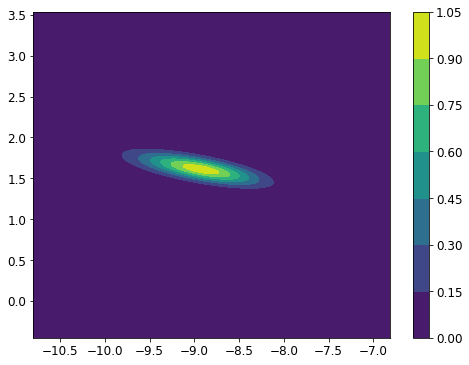

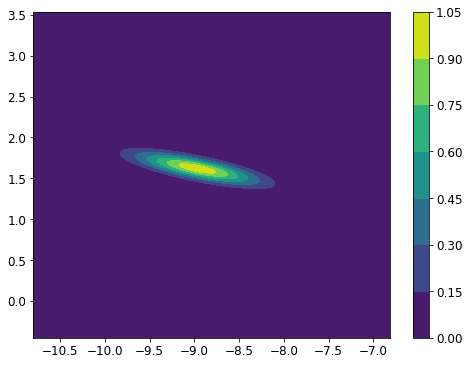

In [6]:
xlim = [theta_range_1.min().item(), theta_range_1.max().item()]
ylim = [theta_range_2.min().item(), theta_range_2.max().item()]
x_grid, y_grid = np.mgrid[xlim[0]:xlim[1]:.01, ylim[0]:ylim[1]:.01]

# first approximation
fig1, ax1 = plt.subplots(1, 1, figsize=(8, 6))
c1 = ax1.contourf(x_grid, y_grid, posterior)
plt.colorbar(c1, ax=ax1)
plt.show()

# second approximation
pos = np.dstack((x_grid, y_grid))
rv = multivariate_normal(variational_mean.numpy(), variational_covar.numpy())
pdf = rv.pdf(pos)
scaled_pdf = pdf / pdf.max()
    
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 6))
c2 = ax2.contourf(x_grid, y_grid, scaled_pdf)
plt.colorbar(c2, ax=ax2)
plt.show()